In [1]:
import glob
import math
import os
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/home/whiterab22bit/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
raw_data=pd.read_csv('/home/whiterab22bit/train_mnist.csv')
raw_data = raw_data.head(7000)


In [4]:
#mnist data is almost ready for use, I am just converting it to numpy and splitting it for training and validation sets
data = np.asarray(raw_data)
len_train = int(len(data)*0.8)

train_set = data[:len_train]
val_set = data[len_train:]

training_examples = train_set[:, 1:].astype(np.float32)
training_targets = train_set[:, :1]
validation_examples = val_set[:, 1:].astype(np.float32)
validation_targets = val_set[:, :1]

In [10]:
#tf numpy input functions(there is also one for pandas)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": training_examples},
    y=training_targets,
    batch_size=100,
    num_epochs=1,
    shuffle=True)
            
pred_train_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": training_examples},
    y=training_targets,
    num_epochs=1,
    shuffle=False)
pred_val_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": validation_examples},
    y=validation_examples,
    num_epochs=1,
    shuffle=False)

In [11]:
def cnn_model_fn(features, labels, mode):
    
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Configure evaluation metrics
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



In [8]:
def train_cnn_classification_model(
    steps,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 15
    steps_per_period = steps / periods 
    
    
    classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/home/dariagurova91/cnn_dir/")
    
    
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(
            input_fn=train_input_fn,
            steps=steps_per_period
        )
  
        # Predicting for metrics.loss
        training_predictions = list(classifier.predict(input_fn=pred_train_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
        validation_predictions = list(classifier.predict(input_fn=pred_val_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)
        
        # Calculating loss
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    
        print("  period %02d : %0.2f" % (period, validation_log_loss))
    
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Final accuracy
    final_predictions = classifier.predict(input_fn=pred_val_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])
  
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    
    return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 0.30
  period 01 : 0.39
  period 02 : 0.39
  period 03 : 0.39
  period 04 : 0.35
  period 05 : 0.35
  period 06 : 0.30
  period 07 : 0.30
  period 08 : 0.32
  period 09 : 0.37
Model training finished.
Final accuracy (on validation data): 0.99


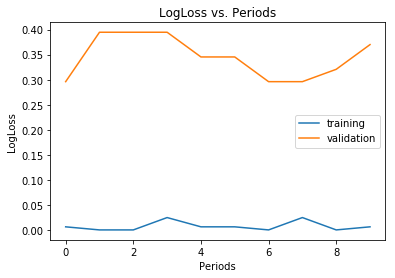

In [64]:
classifier = train_cnn_classification_model(
    steps=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [65]:
test_mnist = pd.read_csv('/home/dariagurova91/test_mnist.csv', sep=',')
test_mnist = test_mnist.values.astype(np.float32)

In [66]:
def test_predict_input_fn(features, batch_size):
    def _input_fn():
        raw_features = {"x": features}
    
        ds = Dataset.from_tensor_slices((raw_features))
        ds = ds.batch(batch_size)
    
        feature_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch
    return _input_fn


predict_test_input_fn = test_predict_input_fn(
    test_mnist, 100)

In [67]:
test_predictions = list(classifier.predict(input_fn=predict_test_input_fn))

test_pred_class = np.array([item['classes'] for item in test_predictions])

In [56]:
test_probabilities = pd.Series(test_pred_class,name="Label")

submiss = pd.concat([pd.Series(range(1,28001),name = "ImageId"),test_probabilities],axis = 1)

submiss.to_csv(path_or_buf="/home/whiterab22bit/mnist_pred.csv",index=False)